In [1]:
import lettuce as lt
import matplotlib.pyplot as plt

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, EquilibriumInletPU, AntiBounceBackOutlet
from lettuce.flows.obstaclemax import ObstacleMax

import torch
import time
import datetime
import os
import shutil

In [2]:
### Simulationsparameter - Steuerung 
output_save = True
if output_save:  # toggle output
    vtk_out = True    # vtk-Repoter für Animation des Flusses in ParaView: True = vtk-output, False = no vtk-output

    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    #output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
    output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
    dir_name = "/data_" + str(timestamp)
    os.makedirs(output_path+dir_name)
else:
    vtk_out = False


re = 200    # Reynoldszahl
n_steps = 500000    # Schrittzahl
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_ou -> this defines the PU-Reference velocity (u_max of inflow)

gridpoints_per_diameter = 80  # gp_per_D -> this defines the resolution
domain_width_in_D = 5  # D/Y  -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2*domain_width_in_D  # D/X

print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", n_steps * (setup_diameter/gridpoints_per_diameter)*(0.05*1/np.sqrt(3)/flow_velocity), "seconds")
print("n_steps to simulatate 1 second:", (gridpoints_per_diameter/setup_diameter)*(flow_velocity/(0.05*1/np.sqrt(3))), "steps")

u_init = 2    # initiales Geschwindigkeitsfeld: 1= alle null, 2= parabelförmiger Verlauf über den Kanal-Qerschnitt
perturb_init = True   # leichte Asymmetrie in Anfangs-Geschwindigkeitsverteilung -> Amplitude kann unten gewählt werden
u_in_parabel = True    # Anströmungsprofil: Parabel oder Uniform
bb_wall = True    # Randbedingungen der lateralen Kanalwände: True= bounce-back-walls, False= periodic
cylinder = True    # Objekt: True = cylinder, False = no obstascle
halfway = True    # BounceBackBoundary: True=halfway, False=Fullway
drag_out = True    # drag_coefficient als observable-reporter
lift_out = True    # lift_coefficient als observable-reporter

if output_save:
    vtk_path = output_path+dir_name+"/vtk/out"    # lokal HBRS UND Bonn # Pfad und Name der vtk-output-Dateien
    vtk_fps=10    # FramesPerSecond (/PU) für vtk-output
    print("dir_name: "+dir_name)
    print("output_path: " + vtk_path)

#exmpl: Re1000,steps25000,ny1000 braucht 43min
#Bonn: Re200, steps200000,400x200 braucht 10min

shape_LU: 800 x 400
T with 500000 steps: 180.42195912175808 seconds
n_steps to simulatate 1 second: 2771.281292110203 steps
dir_name: /data_230313_200506
output_path: /home/max/Documents/lbm_simulations/data_230313_200506/vtk/out


In [3]:
### Simulationssetup

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype

flow = ObstacleMax(reynolds_number=re, mach_number=0.05, 
                   lattice=lattice, 
                   char_length_pu=setup_diameter, 
                   char_length_lu=gridpoints_per_diameter, 
                   char_velocity_pu=flow_velocity, 
                   y_cl=domain_width_in_D, 
                   x_cl=domain_length_in_D, 
                   lateral_walls=bb_wall, 
                   hwbb=halfway, 
                   perturb_init=True, 
                   u_init=2
                  )

# define a Cylinder-Obstacle
radius = 0.5 * flow.char_length_pu
x_pos = 0.25 * flow.domain_length_cl
y_pos = 0.5 * flow.domain_width_cl
x, y = flow.grid
condition = np.sqrt((x - x_pos) ** 2 + (y - y_pos) ** 2) < radius  # (x-x0)²+(y-y0)²<r² in PU
flow.obstacle_mask[np.where(condition)] = 1
    
    
### Simulations-Objekt (Simulator)
tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice, 
                     lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau), 
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if vtk_out == True:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)

# Observable reporter: drag coefficient
if drag_out == True:
    DragObservable = lt.DragCoefficient(lattice,flow,sim,area=setup_diameter)  # erstelle Observable // ! area A=2*r is in PU
    Dragreport = lt.ObservableReporter(DragObservable, out=None)  # erstelle Reporter für Observable
    sim.reporters.append(Dragreport)  # hänge Reporter in Simulator ein
    
# Observable reporter: lift coefficient
if lift_out == True:
    LiftObservable = lt.LiftCoefficient(lattice,flow,sim,area=setup_diameter)
    Liftreport = lt.ObservableReporter(LiftObservable, out=None)
    sim.reporters.append(Liftreport)

In [4]:
### calculate necessary No. of steps to simulate T seconds
T=150
l_char_lu=flow.units.characteristic_length_lu
l_char_pu=flow.units.characteristic_length_pu
u_char_lu=flow.units.characteristic_velocity_lu
u_char_pu=flow.units.characteristic_velocity_pu
n_steps_prediction = T*l_char_lu/l_char_pu*u_char_pu/u_char_lu

print("Domain size:", flow.shape[0], "x", flow.shape[1])

print("steps for", T, "seconds:", n_steps_prediction)

print("time simulated with set", n_steps, "steps:", flow.units.convert_time_to_pu(n_steps), "seconds")

if output_save:
    print("generates approx.", int(vtk_fps*flow.units.convert_time_to_pu(n_steps))+1, ".vti/.vtk-frames")

Domain size: 800 x 400
steps for 150 seconds: 415692.19381653046
time simulated with set 500000 steps: 180.42195912175808 seconds
generates approx. 1805 .vti/.vtk-frames


In [5]:
### Einfache Simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("Re:",re)
print("char_velocity_LU", flow.units.characteristic_velocity_lu)
print("number of steps:",n_steps)
print("runtime: ",time.time()-t_start, "seconds")

MLUPS: 37.37502548067742
PU-Time:  180.42195912175808  seconds
Re: 200
char_velocity_LU 0.028867513459481294
number of steps: 500000
runtime:  4280.933802366257 seconds


  stepLU         timePU         Cd
[[ 0.00000000e+00  0.00000000e+00  4.47552089e+00]
 [ 1.00000000e+00  3.60843918e-04  4.47552089e+00]
 [ 2.00000000e+00  7.21687836e-04 -5.77570288e-01]
 ...
 [ 4.99998000e+05  1.80421237e+02  1.27284576e+00]
 [ 4.99999000e+05  1.80421598e+02  1.27285100e+00]
 [ 5.00000000e+05  1.80421959e+02  1.27285626e+00]]


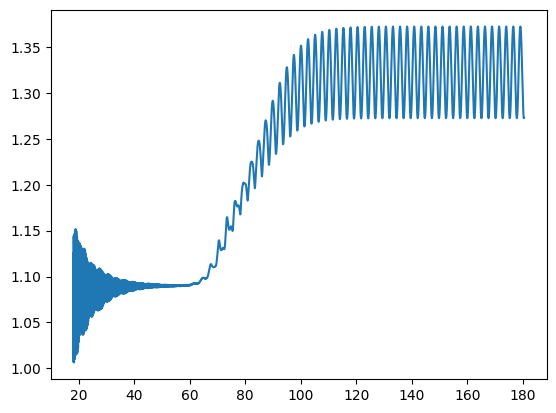

In [6]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
print('  stepLU        ', 'timePU        ', 'Cd')
print(drag_coefficient) # prints: stepLU, timePU, value
plt.figure
plt.plot(drag_coefficient[int(drag_coefficient.shape[0]*0.1):,1],drag_coefficient[int(drag_coefficient.shape[0]*0.1):,2])

In [7]:
drag_coefficient[int(drag_coefficient.shape[0]*0.75):,2].mean()

1.3231739570506873

In [8]:
drag_coefficient[int(drag_coefficient.shape[0]*0.75),1]

135.31646934131857

  stepLU         timePU         Cl
[[ 0.00000000e+00  0.00000000e+00  2.66453526e-14]
 [ 1.00000000e+00  3.60843918e-04 -2.66453526e-14]
 [ 2.00000000e+00  7.21687836e-04  1.59870168e-13]
 ...
 [ 4.99998000e+05  1.80421237e+02  1.90866183e-01]
 [ 4.99999000e+05  1.80421598e+02  1.91129589e-01]
 [ 5.00000000e+05  1.80421959e+02  1.91392955e-01]]


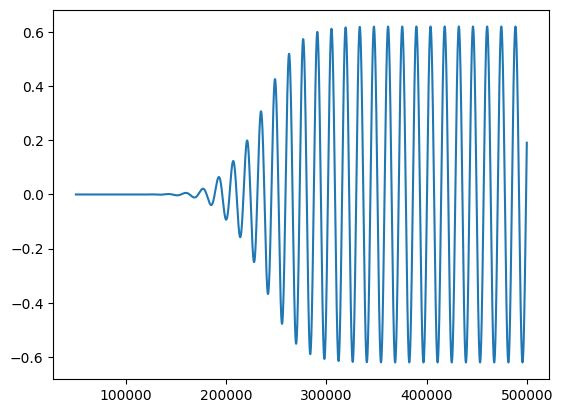

In [9]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
print('  stepLU        ', 'timePU        ', 'Cl')
print(lift_coefficient) # prints: stepLU, timePU, value
plt.figure
plt.plot(lift_coefficient[int(lift_coefficient.shape[0]*0.1):,0],lift_coefficient[int(lift_coefficient.shape[0]*0.1):,2])

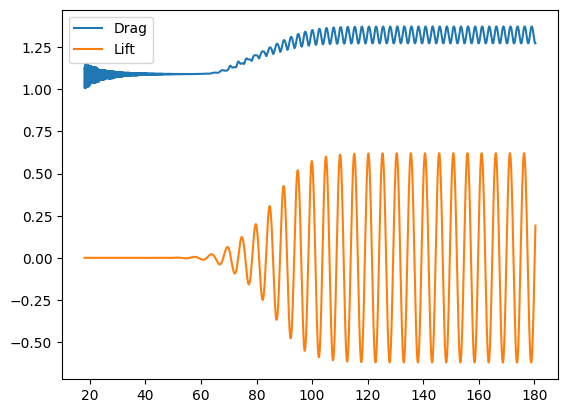

In [10]:
### plot Drag coefficient AND Lift Coefficient

drag_coefficient = np.array(Dragreport.out)
plt.figure
plt.plot(drag_coefficient[int(drag_coefficient.shape[0]*0.1):,1],drag_coefficient[int(drag_coefficient.shape[0]*0.1):,2])
lift_coefficient = np.array(Liftreport.out)
plt.plot(lift_coefficient[int(lift_coefficient.shape[0]*0.1):,1],lift_coefficient[int(lift_coefficient.shape[0]*0.1):,2])
plt.legend(labels=["Drag", "Lift"])

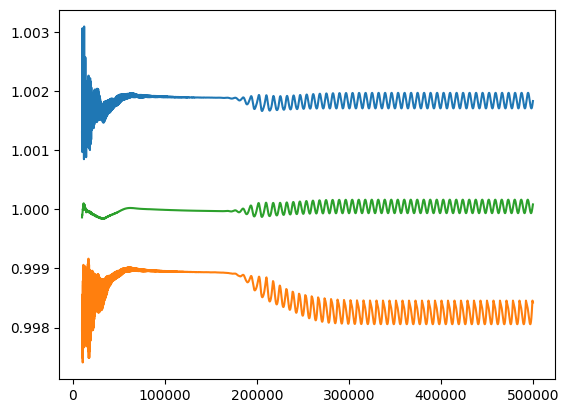

In [11]:
### plotte Dichte (mean, max, min) im Fluid-Bereich

plt.figure
plt.plot(np.arange(len(DragObservable.rho_max_list[10000:]))+10000,DragObservable.rho_max_list[10000:])
plt.plot(np.arange(len(DragObservable.rho_max_list[10000:]))+10000,DragObservable.rho_min_list[10000:])
plt.plot(np.arange(len(DragObservable.rho_max_list[10000:]))+10000,DragObservable.rho_mean_list[10000:])

In [12]:
# save notebook to simulation_output
if output_save:
    shutil.copy(str(os.getcwd())+"/cylinder2D_development.ipynb",output_path+dir_name+"/script.ipynb")
else:
    print("output_save-toggle is FALSE")


In [13]:
print(flow.solid_mask)

[[ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True False False ... False False  True]]


In [14]:
print(flow.obstacle_mask
     )

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [15]:
print(flow.shape)

(800, 400)
